<a href="https://colab.research.google.com/github/MaschinenNah/FramePred2021/blob/main/FramePred2021_01_moving_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage import draw
import numpy as np
from matplotlib import pyplot as plt
import random

!git clone https://github.com/MaschinenNah/ml_utils
from ml_utils import show

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Cloning into 'ml_utils'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 124 (delta 57), reused 86 (delta 26), pack-reused 0
Receiving objects: 100% (124/124), 14.76 KiB | 2.46 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Tue Aug 24 11:56:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                   

###Eine Funktion, die bewegte Objekte in ein Numpy Array "hineinmalt"

Ein Etappenziel besteht darin, einen Generator zu programmieren, der Trainingsdaten für die Frame Prediction erzeugt.

Ein einzelnes Trainingsbeispiel soll aus einer Folge von vorherigen Frames (x) und einer Folge von zukünftigen Frames (y) bestehen.

Wir wollen dabei möglichst flexibel sein: Die Anzahl und Art der bewegten Objekte, die Größe des einzelnen Frames etc. sollen leicht zu ändern sein.

Zu diesem Behufe definieren wir eine Funktion, die den Bewegungsablauf eines einzelnen Objektes in ein Numpy Array hineinmalt.

Das einzige Argument arr ist ein Numpy Array. Hier gibt es nur folgende Vorgaben:

arr[i] ist ein einzelner Frame

Ensprechend bedeutet, wenn arr.shape[0] == 24, dass die Sequenz aus 24 Frames besteht.

Die Ausdehnungen der zweiten und dritten Dimension ist gleich, sprich: Die einzelnen Frames sind quadratisch!

In [2]:
def write_moving_object_into(arr):
  
  # Anzahl der Frames wird direkt aus der shape gefolgert:
  n_frames = arr.shape[0]
  # Ebenso die Größe der Frames:
  frame_size = arr.shape[1]

  # Bestimmung von Ausdehnung, Startposition und Geschwindigkeit des Objektes per Zufall:
  r = random.uniform(frame_size/10, frame_size/5)
  xpos = random.uniform(2*r, frame_size-2*r)
  ypos = random.uniform(2*r, frame_size-2*r)
  xspeed = random.uniform(-frame_size/10., frame_size/10.)
  yspeed = random.uniform(-frame_size/10., frame_size/10.)

  # Kreis oder Quadrat?
  renderer = random.randint(0, 1)

  # Berechnung der Bewegungssequenz:
  for i in range(0, n_frames):

    xpos_new = xpos + xspeed
    if xpos_new < 0 or xpos_new > frame_size:
      xspeed *= -1
    else:
      xpos = xpos_new
    
    ypos_new = ypos + yspeed
    if ypos_new < 0 or ypos_new > frame_size:
      yspeed *= -1
    else:
      ypos = ypos_new

    if renderer == 0:
      for j in range(0, round(frame_size/20)):
        # Hier findet das Malen statt:
        y, x = draw.circle_perimeter(round(xpos), round(ypos), round(r-j), shape=(frame_size, frame_size))
        arr[i, y, x] = 1
      
    elif renderer == 1:
      for j in range(0, round(frame_size/20)):
        # Hier findet das Malen statt:
        y, x = draw.rectangle_perimeter((round(xpos)-r+j, round(ypos)-r+j), extent=(2*r-2*j, 2*r-2*j), shape=(frame_size, frame_size))
        y = y.astype("uint8")
        x = x.astype("uint8")
        arr[i, y, x] = 1

##Die Anwendung der Funktion

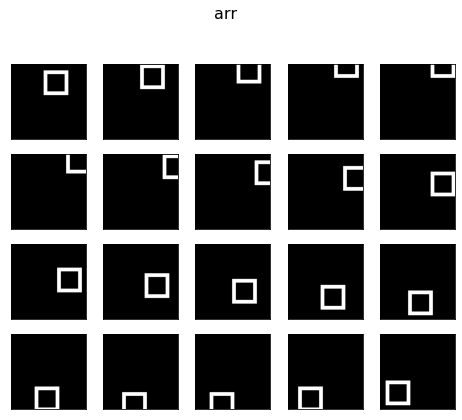

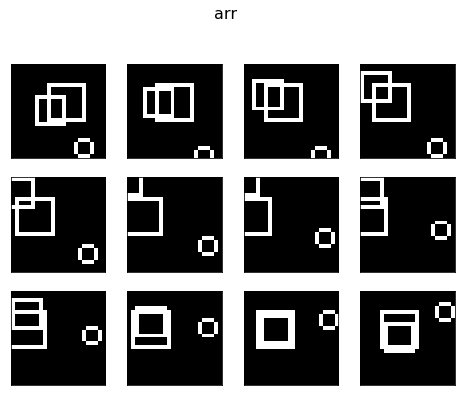

In [3]:
# Hier bauen wir eine Sequenz aus 20 Frames, 200 x 200 Pixel mit einem Objekt:
arr = np.zeros((20, 200, 200))
write_moving_object_into(arr)
show.show_images_from_np_array(arr, "arr")

# Und eine Sequenz aus 12 Frames, 24 x 24:
arr = np.zeros((12, 24, 24))
write_moving_object_into(arr)
write_moving_object_into(arr)
write_moving_object_into(arr)
show.show_images_from_np_array(arr, "arr")

## Ein Generator

In [29]:
from tensorflow.keras.utils import Sequence

class FramePredGen(Sequence):

  def __init__(self,
               frame_shape,
               n_frames_x,
               n_frames_y,
               n_objects,
               object_generator,
               len=50,
               batch_size=50):

    self.frame_shape = frame_shape
    self.n_frames_x = n_frames_x
    self.n_frames_y = n_frames_y
    self.n_objects = n_objects
    self.object_generator = object_generator
    self.len = len
    self.batch_size = batch_size
    
    self.all_examples = []


  def __len__(self):
    return self.len

  def __getitem__(self, batch_index):
    if batch_index >= self.len:
      raise IndexError("batch index out of range")
    else:
      batch_x, batch_y = self._get_empty_batch()
      for example_index in range(self.batch_size):
        all_frames = np.zeros((self.n_frames_x + self.n_frames_y,) + self.frame_shape)
        for object_index in range(self.n_objects):
          self.object_generator(all_frames)

        x = all_frames[:self.n_frames_x]
        y = all_frames[self.n_frames_x:]
        batch_x[example_index] = x
        batch_y[example_index] = y

      return batch_x, batch_y

  # Hilfsfunktion – Erzeugung leerer Batches:
  def _get_empty_batch(self):
    empty_batch_x = np.zeros((self.batch_size,) + (self.n_frames_x,) + (self.frame_shape), "float32")
    empty_batch_y = np.zeros((self.batch_size,) + (self.n_frames_y,) + (self.frame_shape), "float32")
    return empty_batch_x, empty_batch_y



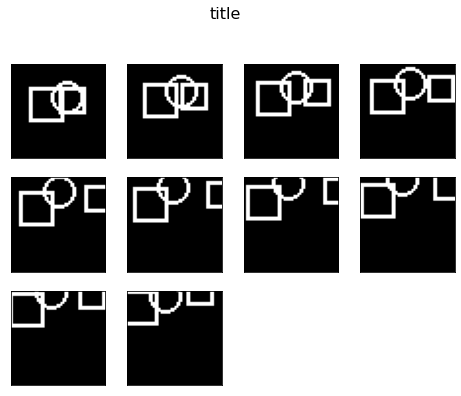

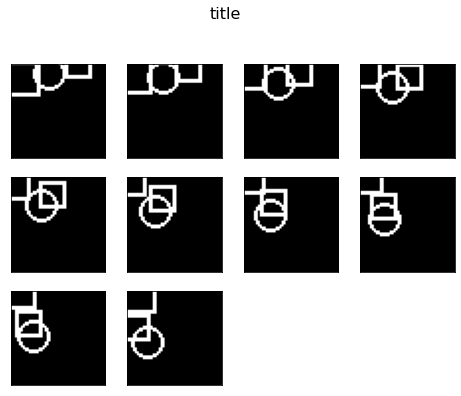

In [5]:
gen = FramePredGen((48, 48), 10, 10, 3, write_moving_object_into)

batch = gen[0]

show.show_images_from_np_array(batch[0][0], "title")
show.show_images_from_np_array(batch[1][0], "title")

In [31]:
import numpy as np

from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

input_shape = (10, 48, 48)
output_shape = (1, 48, 48)

input_layer = Input(shape=input_shape)

x = Flatten()(input_layer)

x = Dense(10000, activation="tanh")(x)

x = Dense(5000, activation="tanh")(x)

x = Dense(2500, activation="tanh")(x)

x = Dense(2500, activation="tanh")(x)

x = Dense(2500, activation="tanh")(x)

x = Dense(2500, activation="tanh")(x)

x = Dense(2500, activation="tanh")(x)

x = Dense(2500, activation="tanh")(x)

x = Dense(2500, activation="tanh")(x)

x = Dense(2304, activation="sigmoid")(x)

output_layer = Reshape(output_shape)(x)

model = Model(input_layer, output_layer)

model.summary()


ResourceExhaustedError: ignored

In [27]:
from scipy import ndimage
import tensorflow as tf


optimizer = Adam(learning_rate=0.00025)

def loss(y_true, y_pred):
  #blurriness = K.sum(blur_detect(y_pred))
  unequality = K.mean(K.square(y_true - y_pred), axis = [1,2])
  #idleness = 0;
  return unequality

model.compile(loss=loss, optimizer=optimizer)

In [28]:
model.fit(gen, epochs=1000)

Epoch 1/1000


InvalidArgumentError: ignored

In [10]:
def predict_single(model, input):
  input = input[np.newaxis, ...]
  output = model.predict(input)[0]
  return output

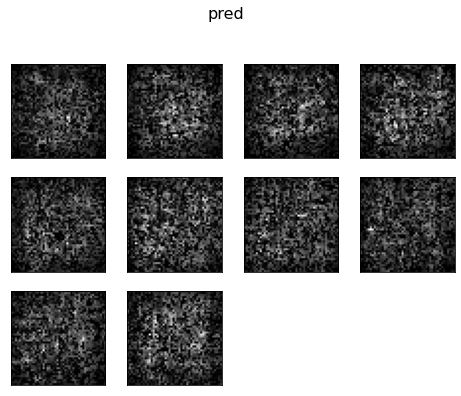

In [24]:
pred = model.predict(gen[0][0])
show.show_images_from_np_array(pred, "pred")